/tmp/ipykernel_6537/2362364589.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample['lam'][i, j] = stats.gamma.rvs(nu1 / 2, size=1, scale=2 / nu2)


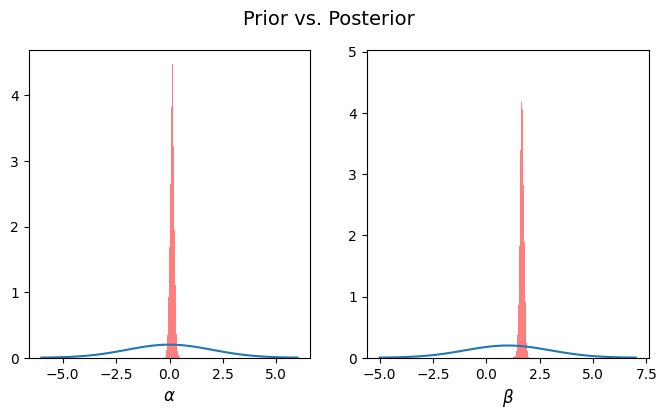

In [3]:
# NVDA regression - Bayesian

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
#from progressbar import progressbar

# Linear regression with Student-t errors
def full_run(y, x, n, beta0, B0, alpha0, delta0, nu0):
    # Initialization
    sample = {'beta': np.zeros((n, len(beta0))), 'sig2': np.zeros((n, 1)), 'lam': np.zeros((n, len(y)))}
    sample['beta'][0, :] = beta0
    sample['sig2'][0] = (delta0 / 2) / (alpha0 / 2 - 1)
    sample['lam'][0, :] = 1
    alpha1 = alpha0 + len(y)
    nu1 = nu0 + 1
    
    # Sampling
    for i in range(1, n):
        B1 = np.linalg.inv(x.T @ np.diag(sample['lam'][i - 1, :]) @ x / sample['sig2'][i - 1] + np.linalg.inv(B0))
        beta1 = B1 @ (x.T @ np.diag(sample['lam'][i - 1, :]) @ y / sample['sig2'][i - 1] + np.linalg.inv(B0) @ beta0.reshape(-1,1))
        sample['beta'][i, :] = stats.multivariate_normal.rvs(size=1, mean=beta1.ravel(), cov=B1)
        
        err = y - x @ sample['beta'][i, :].reshape(-1, 1)
        delta1 = delta0 + err.T @ np.diag(sample['lam'][i - 1, :]) @ err
        sample['sig2'][i] = stats.invgamma.rvs(alpha1 / 2, size=1, scale=delta1 / 2)

        for j in range(len(y)):
            nu2 = nu0 + err[j]**2 / sample['sig2'][i]
            sample['lam'][i, j] = stats.gamma.rvs(nu1 / 2, size=1, scale=2 / nu2)
        
    return sample

# Import stock return data
with open("NVDA.csv", "r") as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

data = np.array(data, dtype=float)
y = data[:, header.index('HPR NVDA')].reshape(-1, 1)
x = np.zeros((len(y), 2))
x[:, 0] = 1
x[:, 1] = data[:, header.index('HPR QQQ')]

# Prior and posterior
beta0 = np.array([0, 1])
B0 = np.array([[4, 0], [0, 4]])
alpha0 = 5
delta0 = 5
nu0 = 5
sample1 = full_run(y, x, 11000, beta0, B0, alpha0, delta0, nu0)
sample1['beta'] = sample1['beta'][1000:11000, :]
sample1['sig2'] = sample1['sig2'][1000:11000]
sample1['lam'] = sample1['lam'][1000:11000, :]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
alpha = np.linspace(-6, 6, 100)
ax1.plot(alpha, stats.norm.pdf(alpha, loc=0, scale=2))
ax1.hist(sample1['beta'][:, 0], bins=50, density=True, color="red", alpha=0.5)
ax1.set_xlabel(r'$\alpha$', fontsize=12)
beta = np.linspace(-5, 7, 100)
ax2.plot(beta, stats.norm.pdf(beta, loc=1, scale=2))
ax2.hist(sample1['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
ax2.set_xlabel(r'$\beta$', fontsize=12)
fig.suptitle('Prior vs. Posterior', fontsize=14)
plt.show()